# Measures for Interpretability of Class Activation Maps

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git
!pip install -U git+https://github.com/UN-GCPDS/tf-keras-vis.git

In [2]:
import tensorflow as tf

from gcpds.image_segmentation.models import unet_baseline
from gcpds.image_segmentation.datasets.segmentation import InfraredThermalFeet
from gcpds.image_segmentation.losses import DiceCoefficient

In [3]:
dataset = InfraredThermalFeet()
train, *_ = dataset()

train = train.map(lambda img,mask,id_img: (img,mask), 
                                    num_parallel_calls=tf.data.AUTOTUNE)

shape = 256, 256
train = train.map(lambda img,mask: (tf.image.resize(img,shape), tf.image.resize(mask,shape)), 
                                    num_parallel_calls=tf.data.AUTOTUNE)

train = train.batch(32)

Downloading...
From: https://drive.google.com/uc?id=1HZa4pVwlIXCrRIidflB158kmtYGW23Qe&confirm=t
To: /usr/local/lib/python3.10/dist-packages/gcpds/image_segmentation/datasets/segmentation/Datasets/InfraredThermalFeet/InfraredThermalFeet.zip
100%|██████████| 10.6M/10.6M [00:00<00:00, 29.6MB/s]


 Number of images for Partition 1: 111
 Number of images for Partition 2: 9
 Number of images for Partition 3: 46


In [4]:
model = unet_baseline(input_shape=(256,256,1),out_channels=3)

model.compile(loss=DiceCoefficient(), optimizer=tf.keras.optimizers.Adam())
model.fit(train, epochs=100)

Epoch 1/100
4/4 [==============================] - 37s 922ms/step - loss: -0.3639
Epoch 2/100
4/4 [==============================] - 1s 249ms/step - loss: -0.4256
Epoch 3/100
4/4 [==============================] - 1s 250ms/step - loss: -0.4558
Epoch 4/100
4/4 [==============================] - 1s 250ms/step - loss: -0.4803
Epoch 5/100
4/4 [==============================] - 1s 253ms/step - loss: -0.5014
Epoch 6/100
4/4 [==============================] - 1s 234ms/step - loss: -0.5198
Epoch 7/100
4/4 [==============================] - 1s 251ms/step - loss: -0.5345
Epoch 8/100
4/4 [==============================] - 2s 383ms/step - loss: -0.5525
Epoch 9/100
4/4 [==============================] - 2s 407ms/step - loss: -0.5659
Epoch 10/100
4/4 [==============================] - 2s 261ms/step - loss: -0.5776
Epoch 11/100
4/4 [==============================] - 1s 280ms/step - loss: -0.5887
Epoch 12/100
4/4 [==============================] - 1s 253ms/step - loss: -0.5981
Epoch 13/100
4/4 [======

In [11]:
layer_indexes = [i for i,l in enumerate(model.layers) if 'Conv' in l.name]
layer_indexes

[2, 4, 7, 9, 12, 14, 17, 19, 22, 24, 28, 30, 34, 36, 40, 42, 46, 48, 50]

In [8]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt

from gcpds.image_segmentation.class_activation_maps import SegScore

In [9]:
gradcam = Gradcam(model,
                   model_modifier=ReplaceToLinear(),
                  clone=True)

## CAM Dice

$$D^{'}_r = \mathbb{E}_{l}\left\{\mathbb{E}_{n}\Biggl\{   2 \frac{\mathbf{1}^\top \left(\tilde{\mathbf{M}}^r_n \odot \mathbf{S}^r_{nl}\right) \mathbf{1}}{ \mathbf{1}^\top \tilde{\mathbf{M}}^r_n \mathbf{1} + \mathbf{1}^\top \mathbf{S}^r_{nl} \mathbf{1}} :\forall n\in N\Biggl\}:\forall l\in L\right\}, \quad D_{r}^{'}    \in [0,1]$$

In [22]:
from gcpds.image_segmentation.class_activation_maps.measures.partials import cam_dice 

In [39]:
total_layers = len(layer_indexes)
total_samples = 111
target_class = 1 #only for class 1

cam_dice_values = np.zeros(shape=(total_layers, total_samples))

for i,l in enumerate(layer_indexes):
    for j, (img, mask) in enumerate(train.unbatch().batch(1)): 
        score = SegScore(mask,target_class=target_class)
        cam = gradcam(score, 
              img,
              penultimate_layer=l,
              seek_penultimate_conv_layer=False)
        cam = cam[..., None]
        roi = tf.cast(mask == target_class, tf.float32)
        cam_dice_values[i,j] = cam_dice(roi, cam)

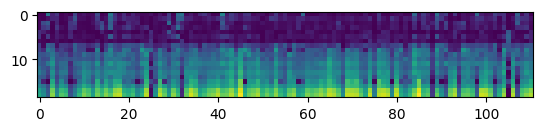

In [40]:
plt.imshow(cam_dice_values)

In [42]:
cam_dice_value = cam_dice_values.mean(axis=1).mean()
cam_dice_value

0.26159253942596367

## CAM-based Cumulative Relevance

$$ \rho_r = \mathbb{E}_{l}\left\{\mathbb{E}_{n}\Biggl\{  \frac{ \mathbf{1}^\top (\tilde{\mathbf{M}}^c_n \odot \mathbf{S}^c_{nl}) \mathbf{1}}{\mathbf{1}^\top \mathbf{S}^c_{nl} \mathbf{1}} : \forall n\in N\Biggl\}\forall l\in L\right\} , \quad \rho_c\in [0,1]$$

In [47]:
from gcpds.image_segmentation.class_activation_maps.measures.partials import cam_cumulative_relevance

In [48]:
total_layers = len(layer_indexes)
total_samples = 111
target_class = 1 #only for class 1

cam_cumulative_values = np.zeros(shape=(total_layers, total_samples))

for i,l in enumerate(layer_indexes):
    for j, (img, mask) in enumerate(train.unbatch().batch(1)): 
        score = SegScore(mask,target_class=target_class)
        cam = gradcam(score, 
              img,
              penultimate_layer=l,
              seek_penultimate_conv_layer=False)
        cam = cam[..., None]
        roi = tf.cast(mask == target_class, tf.float32)
        cam_cumulative_values[i,j] = cam_cumulative_relevance(roi, cam)

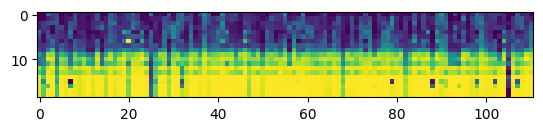

In [49]:
plt.imshow(cam_cumulative_values)

In [50]:
cam_cumulative_values = cam_cumulative_values.mean(axis=1).mean()
cam_cumulative_values

0.5578747539461217

## Mask-based Cumulative Relevance

$$\varrho^{'}_{rl} =  \mathbb{E}_{n}\Biggl\{ \frac{ \mathbf{1}^\top (\tilde{\mathbf{M}}^r_n \odot \mathbf{S}^r_{nl}) \mathbf{1}}{\mathbf{1}^\top \tilde{\mathbf{M}}^r_n \mathbf{1}} : \forall n\in N\Biggl\}, \varrho_{rl}\in\mathbb{R}^+$$

$$\varrho_r = \mathbb{E}_{l}\left\{ \frac{{\varrho^{'}}_{rl}}{{\max\limits_{c \in \{0,1\}} \varrho^{'}_{cl}}} \forall l\in L\right\}, \quad \varrho^{'}_r\in [0,1]$$

In [51]:
from gcpds.image_segmentation.class_activation_maps.measures.partials import masked_cumulative_relevance

In [53]:
total_layers = len(layer_indexes)
total_samples = 111
target_class = 1 #only for class 1

masked_cumulative_values_class_one = np.zeros(shape=(total_layers, total_samples))

for i,l in enumerate(layer_indexes):
    for j, (img, mask) in enumerate(train.unbatch().batch(1)): 
        score = SegScore(mask,target_class=target_class)
        cam = gradcam(score, 
              img,
              penultimate_layer=l,
              seek_penultimate_conv_layer=False)
        cam = cam[..., None]
        roi = tf.cast(mask == target_class, tf.float32)
        masked_cumulative_values_class_one[i,j] = masked_cumulative_relevance(roi, cam)

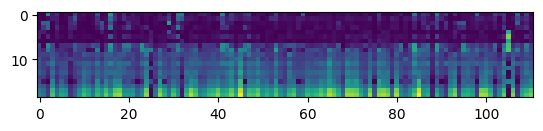

In [57]:
plt.imshow(masked_cumulative_values_class_one)

In [56]:
target_class = 0 #only for class 1

masked_cumulative_values_class_zero = np.zeros(shape=(total_layers, total_samples))

for i,l in enumerate(layer_indexes):
    for j, (img, mask) in enumerate(train.unbatch().batch(1)): 
        score = SegScore(mask,target_class=target_class)
        cam = gradcam(score, 
              img,
              penultimate_layer=l,
              seek_penultimate_conv_layer=False)
        cam = cam[..., None]
        roi = tf.cast(mask == target_class, tf.float32)
        masked_cumulative_values_class_zero[i,j] = masked_cumulative_relevance(roi, cam)

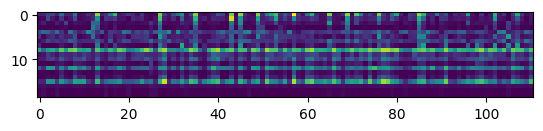

In [58]:
plt.imshow(masked_cumulative_values_class_zero)

In [65]:
masked_cumulative_mean_samples_class_one = masked_cumulative_values_class_one.mean(axis=1, keepdims=True)
masked_cumulative_mean_samples_class_zero = masked_cumulative_values_class_zero.mean(axis=1, keepdims=True)

masked_cumulative_mean_samples = np.concatenate([masked_cumulative_mean_samples_class_one,
                                                 masked_cumulative_mean_samples_class_zero],
                                                axis=1)

In [66]:
masked_cumulative_mean_samples.shape

(19, 2)

In [73]:
masked_cumulative_class_one = masked_cumulative_mean_samples[:,0]/masked_cumulative_mean_samples.max(axis=1)
masked_cumulative_class_zero = masked_cumulative_mean_samples[:,1]/masked_cumulative_mean_samples.max(axis=1)

In [75]:
masked_cumulative_class_one = masked_cumulative_class_one.mean()
masked_cumulative_class_zero = masked_cumulative_class_zero.mean()

In [76]:
masked_cumulative_class_one, masked_cumulative_class_zero

(0.8432377253855776, 0.5880907436847627)